## Score calculation from extracted scores

In [10]:
! pip -q install transformers
! pip -q install numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [11]:
import os
import numpy as np
import re
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score
from transformers import AutoTokenizer

In [12]:
## Get the tokenizer for a model


model_map = {"cambridgeltl":"cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR",
             "dilbert":"beatrice-portelli/DiLBERT",
             "bert-fi":"TurkuNLP/bert-base-finnish-cased-v1",
             "biomed-roberta": "allenai/biomed_roberta_base",
             "bert-en": "google-bert/bert-base-cased",
             "bert-es": "dccuchile/bert-base-spanish-wwm-uncased",
             "biomed-es":"PlanTL-GOB-ES/roberta-base-biomedical-clinical-es"}


lang = "en"
split = "dev"
model = "bert-en"

tokenizer = AutoTokenizer.from_pretrained(model_map[model])

In [13]:
from itertools import zip_longest
def reverse_annotations(text):
    """
    Reverse MEDDOCAN + deepL annotations
    E.g. Name: [#3 Joseo]
    to
    Name: Joseo
    """

    i = re.finditer(r'\[\#[0-9]{1,2}[ ].+?\]', text)
    ind = [[m.start(0),m.end(0)] for m in i]
    current_index=0
    parsed_text=""
    annotations=[]
    for start, end in ind:
        parsed_text = parsed_text + text[current_index:start]
        annot = text[start:end].split(" ")
        pii_class = annot[0].replace("[","")
        annot_text = " ".join(annot[1:]).replace("]","")
        parsed_text += annot_text
        current_index = end
        annotations.append([pii_class, len(parsed_text)-len(annot_text), len(parsed_text)])
    #print(annotations)
    return parsed_text, annotations

# Function to parse TSV data into (word, score) pairs
def parse_tsv_data(tsv_data):
    scores = []
    words = []
    for line in tsv_data.strip().split('\n'):
        score, word = line.split(",",1)
        scores.append(float(score))
        words.append(str(word))
    return scores, words

def create_annotation_token_mask(char_offsets, detokenized, annotations_per_char, use_tags = False):
    """Create a vector with values corresponding to each token-annotation pair."""
    current_annot = 0
    continuation = False
    annotation_mask = []
    for token, (start, end) in zip(detokenized, char_offsets):
        try:
            c_type, c_start, c_end = annotations_per_char[current_annot]
        except IndexError:
            c_type, c_start, c_end = "#0",0,0
        if start == c_start or continuation:
            continuation=False
            if c_end > end:
                continuation = True
                #print(f"{token} [{start}, {end}] \t {c_type}")
                annotation_mask.append(c_type if use_tags else int(c_type[1:]))
                continue
            #print(f"{token} [{start}, {end}] \t {c_type}")
            annotation_mask.append(c_type if use_tags else int(c_type[1:]))
            current_annot += 1
        else:
            #print(f"{token} [{start}, {end}]")
            annotation_mask.append(None if use_tags else 0)
    return annotation_mask


def create_redaction_word_mask(scores, th):
    """Create a mask to see which words should be redacted."""
    return [1 if float(s) < th else 0 for s in scores]


def calculate_metrics(files):

    full_dev_scores = []
    full_dev_annotation_mask = []

    for file in files:
        # locate annotations:
        # /scratch/project_2009498/dippa/zeroshot/scores/en/bert-en
        # /scratch/project_2009498/dippa/deepl/translated_with_annotations/en/dev/<number>
        file_annot = file.replace(f"zeroshot/scores/{lang}/{model}",f"deepl/translated_with_annotations/{lang}/{split}").replace(".csv", ".txt")
        with open(file,"r") as f:
            scores = f.read()
        with open(file_annot, "r") as f:
            annots = f.read()

        # parse scored words
        scores, words = parse_tsv_data(scores)
        # un-annotate, get annotations as locations by char
        parsed_original_text, annotations_per_char = reverse_annotations(annots)
        # tokenize un-annotated text, return character indices
        tokenized = tokenizer(parsed_original_text, return_offsets_mapping=True)
        #print(tokenized)
        #tokenized["input_ids"] = [i for i in tokenized["input_ids"] if i != 101]
        char_offsets = tokenized["offset_mapping"]
        # get token divisions
        retokens = tokenizer.convert_ids_to_tokens(tokenized["input_ids"])
        #retokens = [i for i in retokens if i == "[UNK]"]

        # combine char-level annotations and change them to token level annotations
        annotation_token_mask = create_annotation_token_mask(char_offsets, retokens, annotations_per_char)
        # check that above was done correctly
        assert len(annotation_token_mask) == len(tokenized.word_ids())

        # now, move from token to word level!
        current_idx = -1
        annotation_word_mask = []
        for w_idx, mask, ret in zip(tokenized.word_ids(), annotation_token_mask, retokens):
            if w_idx is not None:
                if w_idx != current_idx:
                    print(f"{words[w_idx]} \t {scores[w_idx]} \t {mask if mask is not None else ''} ({ret})")
                    annotation_word_mask.append(mask)
                    current_idx = w_idx
                else:
                    print(f"\t{words[w_idx]} \t {scores[w_idx]} \t {mask if mask is not None else ''} ({ret})")
        assert len(annotation_word_mask) == len(words), f"{len(annotation_word_mask)} != {len(words)}" # (==len(scores), but we know that from previous)

        # HERE TODO: select which tags to analyse
        annotation_word_mask = [1 if a > 0 else 0 for a in annotation_word_mask]
        full_dev_scores.extend(scores)
        full_dev_annotation_mask.extend(annotation_word_mask)

    accuracies = []
    f1s = []
    recalls = []
    precisions = []
    rocs = []
    for th in np.logspace(0, -20, 100):
        redaction_word_mask = create_redaction_word_mask(full_dev_scores, th)
        accuracies.append(accuracy_score(full_dev_annotation_mask, redaction_word_mask))
        f1s.append(f1_score(full_dev_annotation_mask, redaction_word_mask,  average="binary"))
        recalls.append(recall_score(full_dev_annotation_mask, redaction_word_mask,  average="binary"))
        precisions.append(precision_score(full_dev_annotation_mask, redaction_word_mask, average="binary"))
        rocs.append(roc_auc_score(full_dev_annotation_mask, redaction_word_mask, average="micro"))
    print(accuracies)
    print(f1s)
    print(recalls)
    print(precisions)
    print(rocs)
    return accuracies, f1s, recalls, precisions, rocs


In [14]:
file_paths = os.scandir(f"/scratch/project_2009498/dippa/zeroshot/scores/{lang}/{model}/")
files = [p.path for p in file_paths]

In [15]:
accuracies, f1s, recalls, precisions, rocs = calculate_metrics(files)

Token indices sequence length is longer than the specified maximum sequence length for this model (913 > 512). Running this sequence through the model will result in indexing errors


First 	 0.139866441488266 	 0 (First)
name 	 0.8205047845840454 	 0 (name)
: 	 0.33827996253967285 	 0 (:)
Carlos 	 0.020663544535636902 	 1 (Carlos)
. 	 0.0328020341694355 	 0 (.)
Surname 	 2.47125299210893e-05 	 0 (Sur)
	Surname 	 2.47125299210893e-05 	 0 (##name)
: 	 0.2657923698425293 	 0 (:)
Miguel 	 0.004485561978071928 	 1 (Miguel)
Chamoy 	 1.0058335497831195e-08 	 1 (Cha)
	Chamoy 	 1.0058335497831195e-08 	 1 (##mo)
	Chamoy 	 1.0058335497831195e-08 	 1 (##y)
. 	 0.02038531005382538 	 0 (.)
CIPA 	 6.920909356722404e-08 	 0 (C)
	CIPA 	 6.920909356722404e-08 	 0 (##IP)
	CIPA 	 6.920909356722404e-08 	 0 (##A)
: 	 0.09111728519201279 	 0 (:)
nhc 	 1.4240625567651932e-08 	 0 (n)
	nhc 	 1.4240625567651932e-08 	 0 (##h)
	nhc 	 1.4240625567651932e-08 	 0 (##c)
- 	 0.018565045669674873 	 0 (-)
78912364 	 1.3369510576746735e-12 	 17 (78)
	78912364 	 1.3369510576746735e-12 	 17 (##9)
	78912364 	 1.3369510576746735e-12 	 17 (##12)
	78912364 	 1.3369510576746735e-12 	 17 (##36)
	78912364 	 1.

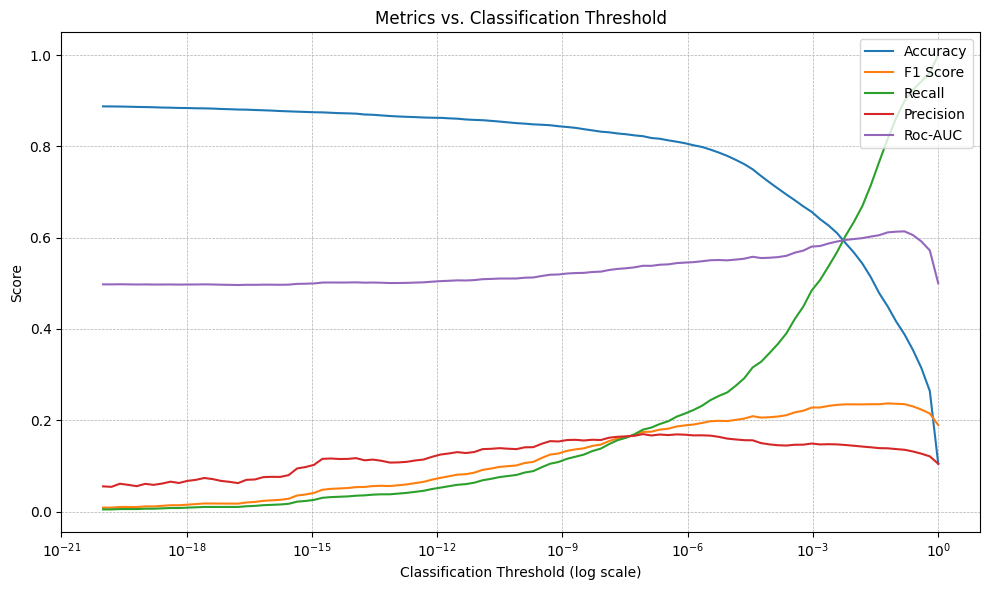

In [16]:
import matplotlib.pyplot as plt


def plot_metrics_vs_threshold(thresholds, accuracies, f1s, recalls, precisions, rocs):
    """
    Plots accuracy, F1 score, recall, and precision against classification thresholds (log scale).

    Parameters:
    - thresholds: array-like, shape (n,) – classification thresholds (logarithmic values)
    - accuracies, f1s, recalls, precisions: array-like, shape (n,) – metric values corresponding to each threshold
    """

    plt.figure(figsize=(10, 6))

    # Plot each metric
    plt.plot(thresholds, accuracies, label='Accuracy')#, marker='o')
    plt.plot(thresholds, f1s, label='F1 Score')#, marker='s')
    plt.plot(thresholds, recalls, label='Recall')#, marker='^')
    plt.plot(thresholds, precisions, label='Precision')#, marker='x')
    plt.plot(thresholds, rocs, label='Roc-AUC')#, marker='x')

    # Log scale for x-axis
    plt.xscale('log')

    # Labels and title
    plt.xlabel('Classification Threshold (log scale)')
    plt.ylabel('Score')
    plt.title('Metrics vs. Classification Threshold')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics_vs_threshold(np.logspace(0, -20, 100), accuracies, f1s, recalls, precisions, rocs)